In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

import time

from joblib import Parallel, delayed, cpu_count
from matplotlib import cm

In [2]:
# # output_plot_dir = "plot/"

# plt.rcParams.update({
#     'font.size': 18,         # Set default font size
#     'lines.linewidth': 4     # Set default line width
# })
# # plt.rcParams['font.sans-serif']=['Arial']
# plt.rcParams['axes.unicode_minus']=False


In [3]:
xlim = [-8,1.5]
def box(x,xlim = xlim):
    if x>max(xlim):
        return max(xlim)
    elif x<min(xlim):
        return min(xlim)
    else:
        return x

In [4]:
def min_g(x0,y0,eta, dgy, epsilon = 1e-4,max_iters = 1000):
    pg = 100
    k = 0

    y_ = y0

    while np.linalg.norm(pg) > epsilon and k < max_iters:
        y = y_
        y_ = y - eta*dgy(x0,y)
        y_ = box(y_)

        pg=1/eta*np.array([y-y_])
        k+=1

    return y_

def min_h(x0,y0,eta, dfy, dgy, gam=10, epsilon = 1e-2,max_iters = 1000):
    def dHy(x,y):
        return 1/gam*dfy(x,y)+dgy(x,y)
    return min_g(x0,y0,eta, dHy, epsilon,max_iters)

In [5]:
def solveF(x0,y0, eta_x, eta_y, dfx, dfy, dgx, dgy,gam=10, box=box,epsilon=1e-8,max_iters=1000,inner_max_iters=100,no_value=True,output_F = True):
    ls=[]
    pg = 1000
    pgs=[]
    x_ = box(x0)
    y_g = y0
    k=0

    xs = [x0]
    ys = [y0]

    dfxs = []
    dgxs_yf = []
    dgxs_yg = []

    while np.linalg.norm(pg) > epsilon and k < max_iters:
        x=x_
        y=y_g

        y_g = min_g(x,y,eta_y, dgy,epsilon,inner_max_iters)
        y_F = min_h(x,y_g, eta_y, dfy, dgy, gam, epsilon, inner_max_iters)

        dF = dfx(x,y_F) if no_value else dfx(x,y_F)+gam*(dgx(x,y_F)-dgx(x,y_g))

        dfxs.append(dF)

        x_ = box(x-eta_x*dF)
        dgxs_yf.append(dgx(x, y_F))
        dgxs_yg.append(dgx(x, y_g))
        pg=1/eta_x*np.array([x-x_,y-y_g])

        pgs.append(float(np.linalg.norm(pg)))
        ls.append(float(np.abs(y+x)))

        xs.append(x_)
        ys.append(y_g)
        k+=1

    if output_F:
        return (x,y_F,k), (pgs, ls, xs, ys), (dfxs, dgxs_yf, dgxs_yg)
    else:
        return (x,y_g,k), (pgs, ls, xs, ys), (dfxs, dgxs_yf, dgxs_yg)

In [6]:
def solveH(x0,y0, eta_x, eta_y, dfx, dfy, dgx, dgy,gam=10, box=box,epsilon=0.01,max_iters=1000,no_value=True,output_F = True):
    ls=[]
    pg = 1000
    pgs=[]
    x_ = box(x0)
    y_ = y_g_ = y0
    k = 0

    xs = [x0]
    ys = [y0]

    dfxs = []
    dgxs_yf = []
    dgxs_yg = []

    while np.linalg.norm(pg) > epsilon and k < max_iters:
        x=x_
        y=y_
        y_g=y_g_

        y_g = min_g(x,y_g_,eta_y, dgy,epsilon,max_iters)
        # y_F = min_h(x,y_g, eta_y, dfy, dgy, gam, epsilon, max_iters)

        dH_x = dfx(x,y) if no_value else dfx(x,y)+gam*(dgx(x,y)-dgx(x,y_g))
        dH_y = dfy(x,y)+gam*dgy(x,y)

        dfxs.append(dH_x)

        x_ = box(x-eta_x*dH_x)
        y_ = box(y-eta_y*dH_y)
        dgxs_yf.append(dgx(x, y_))
        dgxs_yg.append(dgx(x, y_g))
        pg=1/eta_x*np.array([x-x_,y-y_])

        pgs.append(float(np.linalg.norm(pg)))
        ls.append(float(np.abs(y+x)))

        xs.append(x_)
        ys.append(y_)
        k+=1

    if output_F:
        return (x,y_,k), (pgs, ls, xs, ys), (dfxs, dgxs_yf, dgxs_yg)
    else:
        return (x,y_g,k), (pgs, ls, xs, ys), (dfxs, dgxs_yf, dgxs_yg)

In [7]:
def run_exp(i, gam,eta_x, eta_y, dfx, dfy, dgx, dgy,epsilon=1e-4, solver = solveF, no_value=True,output_F = True):

    x=np.random.uniform(0,3.5)
    y=np.random.uniform(-5,8.5)
    lamb = np.random.uniform(0, 10)

    try:
        t_start = time.time()
        (x,y,k), _, _ = solver(x,y, eta_x, eta_y, dfx, dfy, dgx, dgy,gam = gam, no_value=no_value,output_F = output_F)
        t_elapsed = (time.time() - t_start)
    except OverflowError:
        x = -1
        y = -1
        k = -1
        t_elapsed = -1

    return x, y, k, t_elapsed

In [8]:
def g(x, y):
    return (y-x+1)**2

def dgx(x,y):
    return -(y-x+1)*2

def dgy(x,y):
    return (y-x+1)*2

def dg(x,y):
    return np.array([dgx(x,y), dgy(x,y)])


def f(x,y):
    return 10*y+x**2

def f_np(x,y):
    return 10*y+x**2

def dfx(x,y):
    return 2*x

def dfy(x,y):
    return 10

def df(x,y):
    return np.array([dfx(x,y), dfy(x,y)])

Text(0.5, 0, 'Number of iterations needed until convergence')

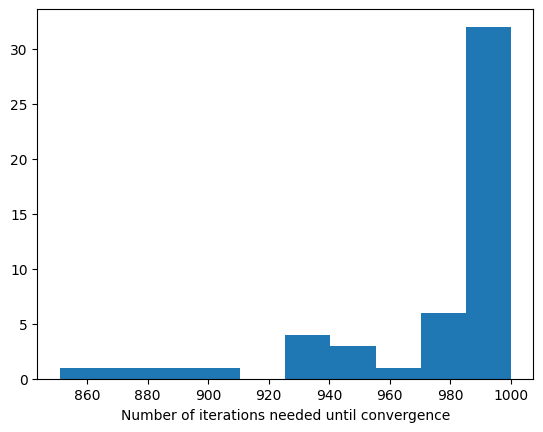

In [9]:
n_jobs = cpu_count()
N = 50 #200
gam = 15
eta_x = eta_y = 0.01
results = Parallel(n_jobs=n_jobs)(delayed(run_exp)(i, gam,eta_x, eta_y, dfx, dfy, dgx, dgy, output_F = False) for i in range(N))
results2 = Parallel(n_jobs=n_jobs)(delayed(run_exp)(i, gam,eta_x, eta_y, dfx, dfy, dgx, dgy,no_value = False, output_F = False) for i in range(N))
results3 = Parallel(n_jobs=n_jobs)(delayed(run_exp)(i, gam,eta_x, eta_y, dfx, dfy, dgx, dgy,no_value = False) for i in range(N))

ps = np.array(results)
ps2 = np.array(results2)
ps3 = np.array(results3)
plt.hist(ps[:,2])
plt.xlabel("Number of iterations needed until convergence")

In [10]:
# find the landscape of orignial problem

Xx = np.linspace(xlim[0],xlim[1],100)
Yy = np.linspace(xlim[0],xlim[1],100)
X, Y = np.meshgrid(Xx, Yy)
Z = f_np(X, Y)

Yyg = Yy
for i in range(len(Yyg)):
    y0 = Yyg[i-1] if i>1 else  Yyg[i]
    Yyg[i]=min_g(Xx[i],y0,0.001, dgy, epsilon=1e-4)

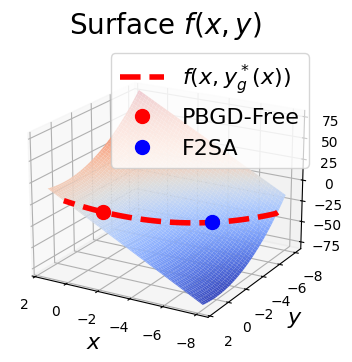

In [11]:
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(6,4))
fig = plt.figure(figsize=(4, 4.5))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(Y,X, Z, cmap=cm.coolwarm, alpha=1.)#, rstride=1, cstride=1)

ax.plot( Yyg[10:],Xx[10:], f_np(Xx[10:], Yyg[10:]), 'r--', zorder=10,linewidth=4,label = r"$f(x,y_g^*(x))$")

# for i in range(N):
i=1
ax.plot(ps[i,1], ps[i,0], f(ps[i,0], ps[i,1]), 'o', color='r', markersize=10,zorder=10,alpha=1,label="PBGD-Free") #output y_g; no value
# ax.plot(ps3[i,1],ps3[i,0], f(ps3[i,0], ps3[i,1]), 'o', color='g', markersize=10,zorder=10,alpha=0.8) # output y_F; value
ax.plot(ps2[i,1],ps2[i,0], f(ps2[i,0], ps2[i,1]), 'o', color='b', markersize=10,zorder=10,alpha=1,label="F2SA") # output y_g; value



ax.set_xlabel(r'$x$', fontsize=16)
ax.set_ylabel(r'$y$', fontsize=16)
ax.legend(fontsize=16)
# ax.tick_params(axis='x', labelsize=6)  # X-axis tick labels
# ax.tick_params(axis='y', labelsize=6)  # Y-axis tick labels
# ax.tick_params(axis='z', labelsize=6)  # Z-axis tick labels
# ax.legend(['f(x,y)','$z=f(x,y)|_{y=x}$', 'No value function', 'With value function'], fontsize=16)
ax.view_init(elev=20, azim=120)
ax.set_title(r'Surface $f(x,y)$', fontsize=20)
plt.savefig('plots/example1_3d_plot.pdf',bbox_inches='tight')